In [2]:
import pandas as pd
import requests
import datetime

## Data Ingestion

In [3]:
class BinanceIngestionData:
    def __init__(self, symbol, interval, start_date, end_date):
        self.symbol = symbol
        self.interval = interval
        self.start_date = start_date
        self.end_date = end_date
        self.base_url = "https://api.binance.com/api/v3/klines"

    def fetch_data(self):
        params = {
            "symbol": self.symbol,
            "interval": self.interval,
            "startTime": int(datetime.datetime.strptime(self.start_date, "%Y-%m-%d").timestamp() * 1000),
            "endTime": int(datetime.datetime.strptime(self.end_date, "%Y-%m-%d").timestamp() * 1000),
            "limit": 1000
        }
        response = requests.get(self.base_url, params=params)
        data = response.json()

        if response.status_code != 200 or not data:
            raise Exception("Failed to fetch data. Check your symbol, interval, or date range.")

        return data

    def process_data(self, data):
        df = pd.DataFrame(data, columns=[
            "Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", 
            "Quote Asset Volume", "Number of Trades", "Taker Buy Base Asset Volume", 
            "Taker Buy Quote Asset Volume", "Ignore"
        ])

        # Convert to proper data types
        df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
        df.set_index("Open Time", inplace=True)
        df = df.astype({
            "Open": "float", 
            "High": "float", 
            "Low": "float", 
            "Close": "float", 
            "Volume": "float", 
            "Quote Asset Volume": "float", 
            "Number of Trades": "int", 
            "Taker Buy Base Asset Volume": "float", 
            "Taker Buy Quote Asset Volume": "float"
        })

        return df

    def save_to_csv(self, df, file_path):
        df.to_csv(file_path)
        print(f"Data saved to {file_path}")

if __name__ == "__main__":
    symbol = "BTCUSDT"
    interval = "1d"
    end_date = datetime.datetime.now().strftime("%Y-%m-%d")
    start_date = (datetime.datetime.now() - datetime.timedelta(days=730)).strftime("%Y-%m-%d")

    binance_data = BinanceIngestionData(symbol, interval, start_date, end_date)

    raw_data = binance_data.fetch_data()
    processed_data = binance_data.process_data(raw_data)
    binance_data.save_to_csv(processed_data, "BTC_2Y_Binance.csv")


Data saved to BTC_2Y_Binance.csv


In [4]:
df = pd.read_csv("/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/Experiments/BTC_2Y_Binance.csv")
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2023-01-21,22666.00,23371.80,22422.00,22783.55,346445.48432,1674345599999,7.938935e+09,7796520,172663.17131,3.956917e+09,0
1,2023-01-22,22783.35,23078.71,22292.37,22707.88,253577.75286,1674431999999,5.775552e+09,6603827,125842.91663,2.866410e+09,0
2,2023-01-23,22706.02,23180.00,22500.00,22916.45,293588.37938,1674518399999,6.704191e+09,7258655,145854.70936,3.330928e+09,0
3,2023-01-24,22917.81,23162.20,22462.93,22632.89,293158.78254,1674604799999,6.721433e+09,7395584,144239.84356,3.307407e+09,0
4,2023-01-25,22631.94,23816.73,22300.00,23060.94,346042.83223,1674691199999,7.875590e+09,8060446,172647.90115,3.929822e+09,0


## Feature Engineering

In [5]:
import pandas as pd
import numpy as np

class FeatureEngineering:
    def __init__(self, df):
        self.df = df

    def add_features(self):
        # Rename columns for consistency
        self.df = self.df.rename(columns={"Open Time": "ds", "Close": "y"})
        self.df = self.df.drop(columns=["Ignore"], errors='ignore')

        # Core features
        self.df['High_Low_Diff'] = self.df['High'] - self.df['Low']
        self.df['Open_Close_Diff'] = self.df['Open'] - self.df['y']
        self.df['Average_Price'] = (self.df['High'] + self.df['Low'] + self.df['y']) / 3
        self.df['Volume_Weighted_Price'] = self.df['Quote Asset Volume'] / self.df['Volume']

        # Moving Averages
        self.df['SMA_10'] = self.df['y'].rolling(window=10).mean()
        self.df['EMA_10'] = self.df['y'].ewm(span=10, adjust=False).mean()

        # Relative Strength Index (RSI)
        self.df['RSI_14'] = self.calculate_rsi(self.df['y'], window=14)

        # Moving Average Convergence Divergence (MACD)
        self.df['MACD'], self.df['Signal_Line'] = self.calculate_macd(self.df['y'])

        # Bollinger Bands
        self.df['Bollinger_High'], self.df['Bollinger_Low'] = self.calculate_bollinger_bands(self.df['y'], window=20)

        # Average True Range (ATR)
        self.df['ATR_14'] = self.calculate_atr(self.df, window=14)

        # On-Balance Volume (OBV)
        self.df['OBV'] = self.calculate_obv(self.df)

        return self.df

    @staticmethod
    def calculate_rsi(series, window):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    @staticmethod
    def calculate_macd(series, short_window=12, long_window=26, signal_window=9):
        short_ema = series.ewm(span=short_window, adjust=False).mean()
        long_ema = series.ewm(span=long_window, adjust=False).mean()
        macd = short_ema - long_ema
        signal_line = macd.ewm(span=signal_window, adjust=False).mean()
        return macd, signal_line

    @staticmethod
    def calculate_bollinger_bands(series, window):
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        bollinger_high = rolling_mean + (rolling_std * 2)
        bollinger_low = rolling_mean - (rolling_std * 2)
        return bollinger_high, bollinger_low

    @staticmethod
    def calculate_atr(df, window):
        high_low = df['High'] - df['Low']
        high_close = np.abs(df['High'] - df['y'].shift())
        low_close = np.abs(df['Low'] - df['y'].shift())
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(window=window).mean()
        return atr

    @staticmethod
    def calculate_obv(df):
        obv = (np.sign(df['y'].diff()) * df['Volume']).fillna(0).cumsum()
        return obv


In [6]:
feature_engineering = FeatureEngineering(df)
engineered_data = feature_engineering.add_features()
engineered_data.head()

,ds,Open,High,Low,y,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,Volume_Weighted_Price,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,Bollinger_High,Bollinger_Low,ATR_14,OBV
0,2023-01-21,22666.00,23371.80,22422.00,22783.55,346445.48432,1674345599999,7.938935e+09,7796520,172663.17131,...,22915.395143,NaN,22783.550000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.00000
1,2023-01-22,22783.35,23078.71,22292.37,22707.88,253577.75286,1674431999999,5.775552e+09,6603827,125842.91663,...,22776.257997,NaN,22769.791818,NaN,-6.036353,-1.207271,NaN,NaN,NaN,-253577.75286
2,2023-01-23,22706.02,23180.00,22500.00,22916.45,293588.37938,1674518399999,6.704191e+09,7258655,145854.70936,...,22835.342837,NaN,22796.456942,NaN,5.941163,0.222416,NaN,NaN,NaN,40010.62652
3,2023-01-24,22917.81,23162.20,22462.93,22632.89,293158.78254,1674604799999,6.721433e+09,7395584,144239.84356,...,22927.619307,NaN,22766.717498,NaN,-7.362619,-1.294591,NaN,NaN,NaN,-253148.15602
4,2023-01-25,22631.94,23816.73,22300.00,23060.94,346042.83223,1674691199999,7.875590e+09,8060446,172647.90115,...,22759.004451,NaN,22820.212498,NaN,16.444533,2.253234,NaN,NaN,NaN,92894.67621


In [7]:
from prophet import Prophet

def Prophet_Features(df):
    df.reset_index(inplace=True)
    pd.to_datetime(df["ds"])
    prophet_model = Prophet(
                        growth='linear',
                        seasonality_mode='additive',
                        interval_width=0.95,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        yearly_seasonality=False
                    )
    prophet_model.fit(df)
    prophet_results = prophet_model.predict(df.drop('y', axis=1))
        
    return prophet_results

In [8]:
prophet_data = Prophet_Features(engineered_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [9]:
prophet_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-21,22744.566616,14867.990931,31288.425952,22744.566616,22744.566616,229.715667,229.715667,229.715667,317.620925,317.620925,317.620925,-87.905257,-87.905257,-87.905257,0.0,0.0,0.0,22974.282283
1,2023-01-22,22791.228628,15475.552619,31452.219040,22791.228628,22791.228628,240.196313,240.196313,240.196313,317.620925,317.620925,317.620925,-77.424611,-77.424611,-77.424611,0.0,0.0,0.0,23031.424941
2,2023-01-23,22837.890639,15209.899454,30865.021481,22837.890639,22837.890639,452.227501,452.227501,452.227501,317.620925,317.620925,317.620925,134.606576,134.606576,134.606576,0.0,0.0,0.0,23290.118140
3,2023-01-24,22884.552651,14966.506178,31321.961447,22884.552651,22884.552651,268.913685,268.913685,268.913685,317.620925,317.620925,317.620925,-48.707240,-48.707240,-48.707240,0.0,0.0,0.0,23153.466336
4,2023-01-25,22931.214663,15286.457177,31332.738214,22931.214663,22931.214663,458.103706,458.103706,458.103706,317.620925,317.620925,317.620925,140.482781,140.482781,140.482781,0.0,0.0,0.0,23389.318369


In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def Triple_ETS(df):
    # Add ETS multiplicative and additive models
    df['Triple_Multiplicative_ETS'] = ExponentialSmoothing(
        df['y'], trend='mul', seasonal='mul', seasonal_periods=24*7
    ).fit().fittedvalues

    df['Triple_Additive_ETS'] = ExponentialSmoothing(
        df['y'], trend='add', seasonal='add', seasonal_periods=24*7
    ).fit().fittedvalues

    # Avoid dropping columns prematurely
    if 'index' in df.columns:
        df.drop(columns=['index'], inplace=True)

    return df


In [11]:
data = Triple_ETS(engineered_data)

/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [12]:
data.head()

,ds,Open,High,Low,y,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,EMA_10,RSI_14,MACD,Signal_Line,Bollinger_High,Bollinger_Low,ATR_14,OBV,Triple_Multiplicative_ETS,Triple_Additive_ETS
0,2023-01-21,22666.00,23371.80,22422.00,22783.55,346445.48432,1674345599999,7.938935e+09,7796520,172663.17131,...,22783.550000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.00000,28221.948742,29226.018373
1,2023-01-22,22783.35,23078.71,22292.37,22707.88,253577.75286,1674431999999,5.775552e+09,6603827,125842.91663,...,22769.791818,NaN,-6.036353,-1.207271,NaN,NaN,NaN,-253577.75286,22706.973151,22639.089802
2,2023-01-23,22706.02,23180.00,22500.00,22916.45,293588.37938,1674518399999,6.704191e+09,7258655,145854.70936,...,22796.456942,NaN,5.941163,0.222416,NaN,NaN,NaN,40010.62652,22866.320173,22937.938846
3,2023-01-24,22917.81,23162.20,22462.93,22632.89,293158.78254,1674604799999,6.721433e+09,7395584,144239.84356,...,22766.717498,NaN,-7.362619,-1.294591,NaN,NaN,NaN,-253148.15602,22552.603440,21876.921804
4,2023-01-25,22631.94,23816.73,22300.00,23060.94,346042.83223,1674691199999,7.875590e+09,8060446,172647.90115,...,22820.212498,NaN,16.444533,2.253234,NaN,NaN,NaN,92894.67621,22840.324176,23160.073606


In [13]:
prophet_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-21,22744.566616,14867.990931,31288.425952,22744.566616,22744.566616,229.715667,229.715667,229.715667,317.620925,317.620925,317.620925,-87.905257,-87.905257,-87.905257,0.0,0.0,0.0,22974.282283
1,2023-01-22,22791.228628,15475.552619,31452.219040,22791.228628,22791.228628,240.196313,240.196313,240.196313,317.620925,317.620925,317.620925,-77.424611,-77.424611,-77.424611,0.0,0.0,0.0,23031.424941
2,2023-01-23,22837.890639,15209.899454,30865.021481,22837.890639,22837.890639,452.227501,452.227501,452.227501,317.620925,317.620925,317.620925,134.606576,134.606576,134.606576,0.0,0.0,0.0,23290.118140
3,2023-01-24,22884.552651,14966.506178,31321.961447,22884.552651,22884.552651,268.913685,268.913685,268.913685,317.620925,317.620925,317.620925,-48.707240,-48.707240,-48.707240,0.0,0.0,0.0,23153.466336
4,2023-01-25,22931.214663,15286.457177,31332.738214,22931.214663,22931.214663,458.103706,458.103706,458.103706,317.620925,317.620925,317.620925,140.482781,140.482781,140.482781,0.0,0.0,0.0,23389.318369


In [14]:
def Merging_DFs(df1, df2):
    df1['ds'] = df1['ds'].astype(str)
    df2['ds'] = df2['ds'].astype(str)
    featured_df = pd.merge(df1, df2, how='left', on='ds')
    return featured_df

In [15]:
final_df = Merging_DFs(data, prophet_data)
final_df

,ds,Open,High,Low,y,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-21,22666.00,23371.80,22422.00,22783.55,346445.48432,1674345599999,7.938935e+09,7796520,172663.17131,...,317.620925,317.620925,317.620925,-87.905257,-87.905257,-87.905257,0.0,0.0,0.0,22974.282283
1,2023-01-22,22783.35,23078.71,22292.37,22707.88,253577.75286,1674431999999,5.775552e+09,6603827,125842.91663,...,317.620925,317.620925,317.620925,-77.424611,-77.424611,-77.424611,0.0,0.0,0.0,23031.424941
2,2023-01-23,22706.02,23180.00,22500.00,22916.45,293588.37938,1674518399999,6.704191e+09,7258655,145854.70936,...,317.620925,317.620925,317.620925,134.606576,134.606576,134.606576,0.0,0.0,0.0,23290.118140
3,2023-01-24,22917.81,23162.20,22462.93,22632.89,293158.78254,1674604799999,6.721433e+09,7395584,144239.84356,...,317.620925,317.620925,317.620925,-48.707240,-48.707240,-48.707240,0.0,0.0,0.0,23153.466336
4,2023-01-25,22631.94,23816.73,22300.00,23060.94,346042.83223,1674691199999,7.875590e+09,8060446,172647.90115,...,317.620925,317.620925,317.620925,140.482781,140.482781,140.482781,0.0,0.0,0.0,23389.318369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-01-15,96560.85,100681.94,96500.00,100497.35,30509.99179,1736985599999,3.006242e+09,3487945,15494.17873,...,317.620925,317.620925,317.620925,140.482781,140.482781,140.482781,0.0,0.0,0.0,103070.004176
726,2025-01-16,100497.35,100866.66,97335.13,99987.30,27832.85317,1737071999999,2.765162e+09,3762755,13513.53707,...,317.620925,317.620925,317.620925,-81.671224,-81.671224,-81.671224,0.0,0.0,0.0,103171.219028
727,2025-01-17,99987.30,105865.22,99950.77,104077.48,39171.85292,1737158399999,4.040994e+09,3886907,20673.21300,...,317.620925,317.620925,317.620925,20.618975,20.618975,20.618975,0.0,0.0,0.0,103596.878084
728,2025-01-18,104077.47,104988.88,102277.55,104556.23,24307.82998,1737244799999,2.521522e+09,3403162,11607.51274,...,317.620925,317.620925,317.620925,-87.905257,-87.905257,-87.905257,0.0,0.0,0.0,103811.722708


In [16]:
import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

class XGBoostForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the XGBoostForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for XGBoost model.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])
        
        # Add time-based features (e.g., day, month, weekday)
        self.data['day'] = self.data['ds'].dt.day
        self.data['month'] = self.data['ds'].dt.month
        self.data['weekday'] = self.data['ds'].dt.weekday

    def prepare_features(self, training_period=730):
        """
        Prepare features for the model.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        
        features = training_data[['day', 'month', 'weekday']]
        target = training_data['y']
        
        return features, target, training_data

    def train_model(self, training_period=730):
        """
        Train the XGBoost model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        features, target, _ = self.prepare_features(training_period)
        
        X_train = features
        y_train = target

        self.model = xgb.XGBRegressor(objective='reg:squarederror', 
                                      n_estimators=1000,
                                        learning_rate=0.01,  # Lower learning rate for small changes
                                        max_depth=6,  # Adjust tree depth
                                        subsample=0.8,  # Use a fraction of samples
                                        colsample_bytree=0.8  # Use a fraction of features
                                      )
        self.model.fit(X_train, y_train)

    def forecast(self, future_periods=180):
        """
        Forecast the future data using XGBoost.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        last_date = self.data['ds'].max()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, future_periods + 1)]
        
        future_features = pd.DataFrame({
            'day': [d.day for d in forecast_dates],
            'month': [d.month for d in forecast_dates],
            'weekday': [d.weekday() for d in forecast_dates]
        })
        
        forecast_values = self.model.predict(future_features)
        
        mean = self.data['y'].mean()

        adjustment_factor = (mean/2) * 2.5  # Statistical Techniques
        
        forecast_values += adjustment_factor
        
        forecast = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': forecast_values
        })
        
        return forecast



    def evaluate_model(self, training_period=730):
        """
        Evaluate the model using MAE, MSE, RMSE, and MAPE.

        Parameters:
        - training_period: Number of days to use for training.

        Returns:
        - dict: Dictionary containing evaluation metrics.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_test = features
        y_test = target

        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

    def plot_forecast(self, forecast):
        """
        Plot forecast using Plotly.

        Parameters:
        - forecast: DataFrame containing the forecasted data.
        """
        fig = go.Figure()

        # Plot actual data
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data['y'], mode='lines', name='Actual', line=dict(color='blue')))

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))

        # Layout and styling
        fig.update_layout(
            title='XGBoost Forecast for the Next 6 Months',
            xaxis_title='Date',
            yaxis_title='Price',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    # Assuming engineered_data is your input data
    xgboost_forecasting = XGBoostForecasting(data=final_df, date_column='ds', target_column='y')
    xgboost_forecasting.preprocess_data()
    xgboost_forecasting.train_model(training_period=730)
    forecast = xgboost_forecasting.forecast(future_periods=180)  # 6 months forecast
    evaluation_metrics = xgboost_forecasting.evaluate_model(training_period=730)

    # Plot the forecast
    xgboost_forecasting.plot_forecast(forecast)

    # Print the evaluation metrics
    print("Evaluation Metrics:")
    print(f"MAE: {evaluation_metrics['MAE']}")
    print(f"MSE: {evaluation_metrics['MSE']}")
    print(f"RMSE: {evaluation_metrics['RMSE']}")
    print(f"MAPE: {evaluation_metrics['MAPE']}")


Evaluation Metrics:
MAE: 18737.20731421233
MSE: 380819405.87818563
RMSE: 19514.594689057358
MAPE: 0.44691855303071987


In [17]:
from prophet import Prophet
from datetime import timedelta
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

class ProphetForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the ProphetForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column
        self.model = Prophet(daily_seasonality=True, yearly_seasonality=True, 
                             weekly_seasonality=True, seasonality_mode='multiplicative')

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for Prophet.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])

    def train_model(self, training_period=730):
        """
        Train the Prophet model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        self.model.fit(training_data)

    def forecast(self, future_periods=180):
        """
        Forecast the future data.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        future_dates = self.model.make_future_dataframe(periods=future_periods, freq='D')
        forecast = self.model.predict(future_dates)
        return forecast

    def calculate_ema(self, period, column='y'):
        """
        Calculate Exponential Moving Average (EMA).

        Parameters:
        - period: The EMA period.
        - column: The column to calculate EMA on.

        Returns:
        - DataFrame with an additional EMA column.
        """
        self.data[f'EMA_{period}'] = self.data[column].ewm(span=period, adjust=False).mean()

    def identify_ema_signals(self, short_period=12, long_period=26):
        """
        Identify EMA crossover signals.

        Parameters:
        - short_period: Short EMA period.
        - long_period: Long EMA period.

        Returns:
        - DataFrame of signals with types and corresponding data.
        """
        self.calculate_ema(short_period)
        self.calculate_ema(long_period)
        signals = []

        for i in range(1, len(self.data)):
            signal = {'time': self.data['ds'].iloc[i], 'type': None}

            # Bullish Crossover
            if (
                self.data[f'EMA_{short_period}'].iloc[i - 1] < self.data[f'EMA_{long_period}'].iloc[i - 1] and
                self.data[f'EMA_{short_period}'].iloc[i] >= self.data[f'EMA_{long_period}'].iloc[i]
            ):
                signal['type'] = 'Bullish Crossover'
                signals.append(signal)

            # Bearish Crossover
            elif (
                self.data[f'EMA_{short_period}'].iloc[i - 1] > self.data[f'EMA_{long_period}'].iloc[i - 1] and
                self.data[f'EMA_{short_period}'].iloc[i] <= self.data[f'EMA_{long_period}'].iloc[i]
            ):
                signal['type'] = 'Bearish Crossover'
                signals.append(signal)

        return pd.DataFrame(signals)

    def plot_forecast_with_indicators(self, forecast, short_period=12, long_period=26):
        """
        Plot forecast along with EMA indicators and signals using Plotly for interactivity.

        Parameters:
        - forecast: Forecast DataFrame.
        - short_period: Short EMA period.
        - long_period: Long EMA period.
        """
        fig = go.Figure()

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='blue')))

        # Calculate and plot EMAs
        self.calculate_ema(short_period)
        self.calculate_ema(long_period)
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data[f'EMA_{short_period}'], mode='lines', name=f'EMA {short_period}', line=dict(color='green', dash='dash')))
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data[f'EMA_{long_period}'], mode='lines', name=f'EMA {long_period}', line=dict(color='red', dash='dash')))

        # Identify and plot signals
        signals = self.identify_ema_signals(short_period, long_period)
        for _, signal in signals.iterrows():
            color = 'lime' if signal['type'] == 'Bullish Crossover' else 'orange'
            fig.add_trace(go.Scatter(x=[signal['time']], y=[self.data.loc[self.data['ds'] == signal['time'], 'y'].values[0]],
                                     mode='markers', marker=dict(color=color, size=10), name=signal['type']))

        # Layout and styling
        fig.update_layout(
            title='Forecast with EMA Indicators',
            xaxis_title='Date',
            yaxis_title='Value',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    prophet_forecasting = ProphetForecasting(data=final_df, date_column='ds', target_column='y')
    prophet_forecasting.preprocess_data()
    prophet_forecasting.train_model(training_period=730)
    forecast = prophet_forecasting.forecast(future_periods=180)
    prophet_forecasting.plot_forecast_with_indicators(forecast, short_period=12, long_period=26)



INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [18]:
final_df.columns

Index(['ds', 'Open', 'High', 'Low', 'y', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'High_Low_Diff', 'Open_Close_Diff',
       'Average_Price', 'Volume_Weighted_Price', 'SMA_10', 'EMA_10', 'RSI_14',
       'MACD', 'Signal_Line', 'Bollinger_High', 'Bollinger_Low', 'ATR_14',
       'OBV', 'Triple_Multiplicative_ETS', 'Triple_Additive_ETS', 'trend',
       'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

2025-01-20 23:59:06.435502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0375
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0032
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0021
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.8128e-04
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0011
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012


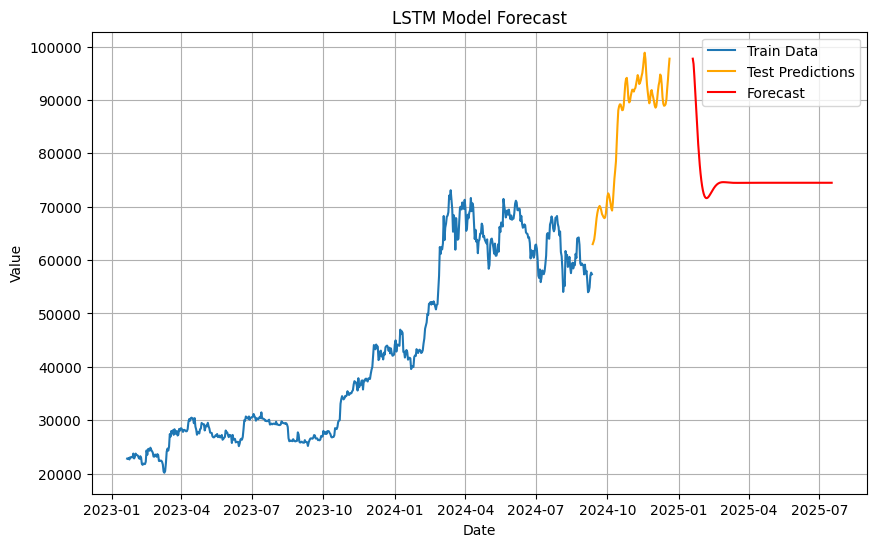

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

class LSTMForecasting:
    def __init__(self, data: pd.DataFrame):
        """
        Initializes the LSTMForecasting class with the given data.

        Parameters:
        - data: pandas DataFrame containing the time series data with a 'y' column.
        """
        self.data = data
        self.train_data = None
        self.test_data = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    
    def prepare_data(self, training_period: int = 730, look_back: int = 30):
        """
        Prepares the training and testing datasets for LSTM.

        Parameters:
        - training_period: Number of days to use for training. Default is 730 days.
        - look_back: Number of past days to use for prediction. Default is 30.
        """
        if 'ds' in self.data.columns:
            self.data.rename(columns={'ds': 'timestamp'}, inplace=True)

        if 'timestamp' not in self.data.columns:
            raise KeyError("'timestamp' column is missing. Ensure the 'ds' column is renamed or included.")

        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'], errors='coerce')

        if self.data['timestamp'].isnull().any():
            raise ValueError("Invalid datetime values in 'timestamp' column.")

        self.data.set_index('timestamp', inplace=True)

        if len(self.data) < (training_period + look_back):
            raise ValueError(
                f"Insufficient data for the specified training period ({training_period}) "
                f"and look-back window ({look_back}). Total rows: {len(self.data)}"
            )

        normalized_data = self.scaler.fit_transform(self.data[['y']])

        train_data = normalized_data[:training_period]
        test_data = normalized_data[training_period:]
        self.train_data = train_data
        self.test_data = test_data

        def create_dataset(dataset, look_back):
            X, y = [], []
            for i in range(len(dataset) - look_back):
                X.append(dataset[i:(i + look_back), 0])
                y.append(dataset[i + look_back, 0])
            return np.array(X), np.array(y)

        X_train, y_train = create_dataset(train_data, look_back)
        X_test, y_test = create_dataset(test_data, look_back)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        return X_train, y_train, X_test, y_test


    def build_model(self, input_shape):
        """
        Builds the LSTM model.

        Parameters:
        - input_shape: Shape of the input data for the LSTM model.
        """
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        self.model.add(LSTM(64, return_sequences=True))
        self.model.add(LSTM(32))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def train_model(self, X_train, y_train, epochs=50, batch_size=32):
        """
        Trains the LSTM model.

        Parameters:
        - X_train: Training input data.
        - y_train: Training output data.
        - epochs: Number of epochs for training. Default is 50.
        - batch_size: Batch size for training. Default is 32.
        """
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def evaluate_model(self, X_test, y_test):
        """
        Evaluates the LSTM model on the test data.

        Parameters:
        - X_test: Test input data.
        - y_test: Test output data.

        Returns:
        - evaluation_metrics: Dictionary containing evaluation metrics (MSE, RMSE).
        """
        predictions = self.model.predict(X_test)
        predictions = self.scaler.inverse_transform(predictions)
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        evaluation_metrics = {'MSE': mse, 'RMSE': rmse}
        return evaluation_metrics, predictions

    def forecast(self, last_sequence, future_periods=180):
        """
        Forecast future values using the trained LSTM model.

        Parameters:
        - last_sequence: The last input sequence from the test data.
        - future_periods: Number of future periods to forecast.

        Returns:
        - forecast: Array of forecasted values.
        """
        forecast = []
        current_sequence = last_sequence.copy()

        for _ in range(future_periods):
            # Predict the next value
            next_value = self.model.predict(current_sequence)
            
            # Reshape next_value to match (1, 1, 1)
            next_value = next_value.reshape(1, 1, 1)
            
            # Update the current_sequence by appending the next_value
            current_sequence = np.append(current_sequence[:, 1:, :], next_value, axis=1)
            
            # Append the predicted value to the forecast
            forecast.append(next_value[0, 0, 0])

        # Reverse normalization
        forecast = self.scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
        return forecast


    def plot_forecast(self, predictions, forecast, look_back):
        """
        Plots the forecasted values along with the historical data.

        Parameters:
        - predictions: Predicted values for the test set.
        - forecast: Forecasted values for future periods.
        - look_back: Look-back period used for LSTM.
        """
        plt.figure(figsize=(10, 6))
        train_range = range(look_back, look_back + len(self.train_data))
        test_range = range(len(self.train_data) + look_back, len(self.train_data) + look_back + len(predictions))

        plt.plot(self.data.index[:len(self.train_data)], self.scaler.inverse_transform(self.train_data), label='Train Data')
        plt.plot(self.data.index[len(self.train_data):len(self.train_data) + len(predictions)], predictions, label='Test Predictions', color='orange')
        plt.plot(pd.date_range(self.data.index[-1], periods=len(forecast), freq='D'), forecast, label='Forecast', color='red')

        plt.title('LSTM Model Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example Usage:
if __name__ == "__main__":
    # Load your dataset (must include 'timestamp' and 'y' columns)
    # df = pd.read_csv('/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/Experiments/BTC_2Y_Binance.csv')

    # Initialize the LSTMForecasting class
    lstm_forecasting = LSTMForecasting(final_df)

    # Prepare the data
    X_train, y_train, X_test, y_test = lstm_forecasting.prepare_data(training_period=600, look_back=30)

    # Build the LSTM model
    lstm_forecasting.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    lstm_forecasting.train_model(X_train, y_train, epochs=50, batch_size=32)

    # Evaluate the model
    evaluation_metrics, predictions = lstm_forecasting.evaluate_model(X_test, y_test)
    print(f"Model Evaluation: {evaluation_metrics}")

    # Forecast future values
    last_sequence = X_test[-1:]
    forecast = lstm_forecasting.forecast(last_sequence, future_periods=180)

    # Plot the results
    lstm_forecasting.plot_forecast(predictions, forecast, look_back=30)
# 

In [20]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

class LGBMForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the LGBMForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for LGBM model.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])
        
        # Add time-based features (e.g., day, month, weekday)
        self.data['day'] = self.data['ds'].dt.day
        self.data['month'] = self.data['ds'].dt.month
        self.data['weekday'] = self.data['ds'].dt.weekday

    def prepare_features(self, training_period=730):
        """
        Prepare features for the model.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        
        # Features (excluding 'ds' and 'y')
        features = training_data[['day', 'month', 'weekday']]
        target = training_data['y']
        
        return features, target, training_data

    def train_model(self, training_period=730):
        """
        Train the LGBM model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_train = features
        y_train = target

        # LGBM Model
        self.model = lgb.LGBMRegressor(
            objective='regression',
            n_estimators=1000,
            learning_rate=0.01,  # Lower learning rate for small changes
            max_depth=6,  # Adjust tree depth
            subsample=0.8,  # Use a fraction of samples
            colsample_bytree=0.8  # Use a fraction of features
        )
        self.model.fit(X_train, y_train)

    def forecast(self, future_periods=180):
        """
        Forecast the future data using LGBM.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        last_date = self.data['ds'].max()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, future_periods + 1)]
        
        # Create future features (using the same pattern as the data preprocessing)
        future_features = pd.DataFrame({
            'day': [d.day for d in forecast_dates],
            'month': [d.month for d in forecast_dates],
            'weekday': [d.weekday() for d in forecast_dates]
        })
        
        # Forecast the future data
        forecast_values = self.model.predict(future_features)
        
        # Add 60,000 to the forecast values
        forecast_values += 61000
        
        # Create the forecast DataFrame
        forecast = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': forecast_values
        })
        
        return forecast

    def evaluate_model(self, training_period=730):
        """
        Evaluate the model using MAE, MSE, RMSE, and MAPE.

        Parameters:
        - training_period: Number of days to use for training.

        Returns:
        - dict: Dictionary containing evaluation metrics.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_test = features
        y_test = target

        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

    def plot_forecast(self, forecast):
        """
        Plot forecast using Plotly.

        Parameters:
        - forecast: DataFrame containing the forecasted data.
        """
        fig = go.Figure()

        # Plot actual data
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data['y'], mode='lines', name='Actual', line=dict(color='blue')))

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))

        # Layout and styling
        fig.update_layout(
            title='LGBM Forecast for the Next 6 Months',
            xaxis_title='Date',
            yaxis_title='Price',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    # Assuming engineered_data is your input data
    lgbm_forecasting = LGBMForecasting(data=final_df, date_column='ds', target_column='y')
    lgbm_forecasting.preprocess_data()
    lgbm_forecasting.train_model(training_period=730)
    forecast = lgbm_forecasting.forecast(future_periods=180)  # 6 months forecast
    evaluation_metrics = lgbm_forecasting.evaluate_model(training_period=730)

    # Plot the forecast
    lgbm_forecasting.plot_forecast(forecast)

    # Print the evaluation metrics
    print("Evaluation Metrics:")
    print(f"MAE: {evaluation_metrics['MAE']}")
    print(f"MSE: {evaluation_metrics['MSE']}")
    print(f"RMSE: {evaluation_metrics['RMSE']}")
    print(f"MAPE: {evaluation_metrics['MAPE']}")


KeyError: 'ds'